In [1]:
import os
import datetime
import pandas as pd
import numpy  as np
import matplotlib.pyplot as plt

import sys
sys.path.append('/home/user/TACTILEDRIVEN_ARTO/UTILITIES')
from PreProcessingFunctions import myfilter, num_transient, sliding_sum_window, select_index, add_padding
from PreProcessingFunctions import WS
from PreProcessingFunctions import rename_and_convert_to_txt

from OrganizeReports import compare_and_organize
from Performance_plotter import plot_f1_score_threshold, plot_precision_recall_curve, plot_confusion_matrix, plot_roc_curve
from ML_models_functions import to_save_model, free_gpu_memory
from XAI_FCN import plot_grad_cam

import sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score, f1_score, classification_report

import tensorflow
gpus = tensorflow.config.list_physical_devices('GPU')
if gpus:    
    for gpu in gpus:
        tensorflow.config.set_logical_device_configuration(
            gpu,
            [tensorflow.config.LogicalDeviceConfiguration(memory_limit=4*1024)])  # Adjust memory limit as needed


from tensorflow.keras.models     import Sequential, Model, load_model
from tensorflow.keras.layers     import Input, Conv1D, Conv2D, BatchNormalization
from tensorflow.keras.layers     import Flatten, Dense, MaxPooling1D, MaxPooling2D, GlobalMaxPooling1D
from tensorflow.keras.layers     import LeakyReLU, ReLU, Activation, Dropout, Lambda
from tensorflow.keras.layers     import concatenate, Concatenate
from tensorflow.keras.optimizers import Adam, AdamW
from tensorflow.keras.losses     import binary_crossentropy, categorical_crossentropy
from tensorflow.keras.metrics    import AUC, Precision, Recall
from tensorflow.keras.callbacks  import EarlyStopping

from tensorflow.keras.utils      import plot_model

data_folder = '/home/user/TACTILEDRIVEN_ARTO/ML_Levers_Knobs/DATA/1D_LEVER_Fx_ScalNorm'

def load_data(data_folder):
    X_data = []
    y_data = []
    # Get list of all .npz files in the data folder
    npz_files = [file for file in os.listdir(data_folder) if file.endswith('.npz')]
    
    # Load data from each .npz file
    for file in npz_files:
        file_path = os.path.join(data_folder, file)
        data = np.load(file_path)
        X_data.append(data['X'])  # Assuming X_data is stored under 'X' key in the .npz file
        y_data.append(data['y'])  # Assuming y_data is stored under 'y' key in the .npz file
        data.close()
    
    # Convert lists to NumPy arrays
    X_data = np.array(X_data)
    y_data = np.array(y_data)
    
    return X_data, y_data

# Load the data
X_data, y_data = load_data(data_folder)

# Check the shape of loaded data
print("X_data shape:", X_data.shape)
print("y_data shape:", y_data.shape)
print("X_data.[0] shape: ", X_data[0].shape)

TEST_SIZE = 0.4
X_train, X_temp, y_train, y_temp = train_test_split(X_data, y_data, test_size=TEST_SIZE, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

print(f"TOTAL DATA: {len(X_data)}  ||  Train = {100*(1-TEST_SIZE)}%  ||  Test = {100*TEST_SIZE}%")
print("Dimensions of X_train:", X_train.shape, "   ||  Dimensions of y_train:", y_train.shape)
print("Dimensions of X_test: ", X_test.shape, "   ||  Dimensions of y_test: ", y_test.shape)
print("Dimensions of X_val:  ", X_val.shape, "   ||  Dimensions of y_val:  ", y_val.shape)

WS_B = 2000
N_CLASS = 3
DISP_LABEL = ["0", "1", "2"]

2024-05-23 17:38:16.407788: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-23 17:38:17.426614: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
2024-05-23 17:38:18.069950: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-05-23 17:38:18.121712: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. 

X_data shape: (802, 2000)
y_data shape: (802,)
X_data.[0] shape:  (2000,)
TOTAL DATA: 802  ||  Train = 60.0%  ||  Test = 40.0%
Dimensions of X_train: (481, 2000)    ||  Dimensions of y_train: (481,)
Dimensions of X_test:  (161, 2000)    ||  Dimensions of y_test:  (161,)
Dimensions of X_val:   (160, 2000)    ||  Dimensions of y_val:   (160,)


# 1st COMBINED (96%)

/home/user/.local/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Model: "functional_133"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_24      │ (None, 2000, 1)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_26      │ (None, 2000, 1)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_13       │ (None, 64)        │     42,464 │ input_layer_24[0… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_14       │ (None, 32)        │    129,800 │ input_layer_26[0… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_6       │ (None, 96)        │          0 │ sequential_13[0]… │
│ (Concatenate)       │                   │            │ sequential_14[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_30 (Dense)    │ (None, 3)         │        291 │ concatenate_6[0]… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 172,555 (674.04 KB)

 Trainable params: 172,555 (674.04 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/32
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 138ms/step - accuracy: 0.4833 - loss: 0.9905 - val_accuracy: 0.4625 - val_loss: 1.0172
Epoch 2/32
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.5725 - loss: 0.8951 - val_accuracy: 0.7063 - val_loss: 0.6941
Epoch 3/32
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.7409 - loss: 0.6186 - val_accuracy: 0.7812 - val_loss: 0.5452
Epoch 4/32
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.8069 - loss: 0.4544 - val_accuracy: 0.7750 - val_loss: 0.6066
Epoch 5/32
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.8445 - loss: 0.4229 - val_accuracy: 0.8625 - val_loss: 0.4385
Epoch 6/32
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.8888 - loss: 0.3028 - val_accuracy: 0.8500 - val_loss: 0.4007
Epoch 7/32
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.8262 - loss: 0.4682 - val_accuracy: 0.8500 - val_loss: 0.4565
Epoch 8/32
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.9128 - loss: 0.2609 - val_accuracy: 0.9062 - 

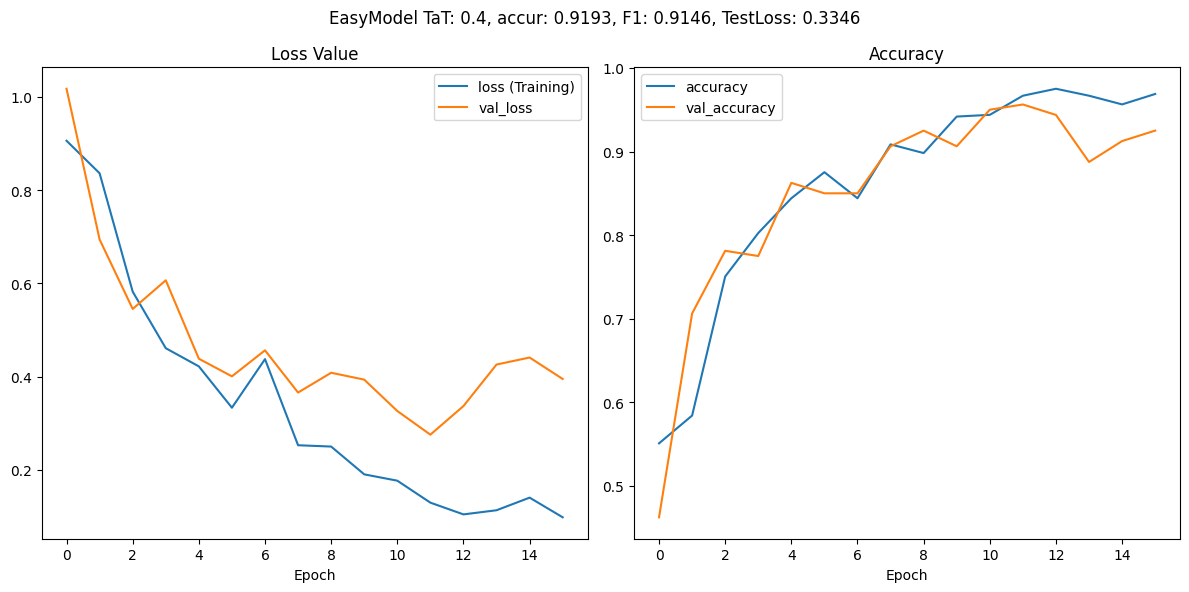

Train loss: 0.09854654222726822
Test val_loss: 0.3950592875480652
Train accuracy: 0.9688149690628052
Accuracy Score: 0.9192546583850931
F1 Score: 0.9146419146419147
Classification Report:
               precision    recall  f1-score   support

         0.0       0.96      0.93      0.95        75
         1.0       0.87      0.91      0.89        53
         2.0       0.91      0.91      0.91        33

    accuracy                           0.92       161
   macro avg       0.91      0.92      0.91       161
weighted avg       0.92      0.92      0.92       161



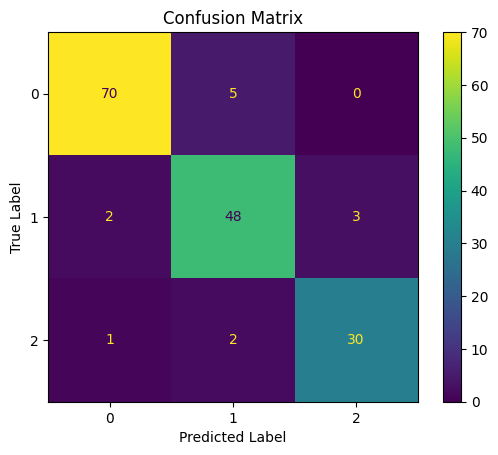

In [8]:
def build_combined_model(input_shape):
    # First Model
    input1 = Input(shape=input_shape)
    model1 = Sequential()
    model1.add(Conv1D(filters=32, kernel_size=40, activation='relu', input_shape=input_shape))
    model1.add(MaxPooling1D(pool_size=4))
    model1.add(Conv1D(filters=64, kernel_size=10, activation='relu'))
    model1.add(MaxPooling1D(pool_size=2))
    model1.add(Conv1D(filters=64, kernel_size=4, activation='relu'))
    model1.add(GlobalMaxPooling1D())
    #model1.add(Flatten())
    model1.add(Dense(64, activation='relu'))
    output1 = model1(input1)

    # Second Model
    input2 = Input(shape=input_shape)
    model2 = Sequential()
    model2.add(Conv1D(filters=32, kernel_size=20, activation='relu', input_shape=input_shape))
    model2.add(MaxPooling1D(pool_size=4))
    model2.add(Conv1D(filters=8, kernel_size=8, activation='relu'))
    model2.add(GlobalMaxPooling1D())
    #model2.add(Flatten())
    model2.add(Dense(64, activation='relu'))
    model2.add(Dropout(rate=0.1))
    model2.add(Dense(32, activation='relu'))
    
    output2 = model2(input2)

    merged = Concatenate()([output1, output2])
    merged = Dense(N_CLASS, activation='softmax')(merged)
    combined_model = Model(inputs=[input1, input2], outputs=merged)

    return combined_model


model = build_combined_model((WS_B, 1))
model.summary()
model.compile(optimizer=Adam(), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

#TRAIN THE MODEL
early_stopping = EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True)
history = model.fit([X_train,X_train], [y_train, y_train], epochs=60, batch_size=32, validation_data=([X_val, X_val], [y_val, y_val]), verbose=1, callbacks=[early_stopping])

loss, accuracy = model.evaluate([X_test, X_test], [y_test, y_test])

# Predict labels for test data
y_pred = model.predict([X_test, X_test])
y_pred_labels = np.argmax(y_pred, axis=1) 

f1 = f1_score(y_test, y_pred_labels, average='macro') 
accuracy = accuracy_score(y_test, y_pred_labels)

fig, axs = plt.subplots(1, 2, figsize=(12, 6))
# Plot Loss Value
axs[0].plot(history.history["loss"], label="loss (Training)")
axs[0].plot(history.history["val_loss"], label="val_loss")
axs[0].set_title("Loss Value")
axs[0].set_xlabel('Epoch')
axs[0].legend()

# Plot Accuracy
axs[1].plot(history.history["accuracy"], label="accuracy")
axs[1].plot(history.history["val_accuracy"], label="val_accuracy")
axs[1].set_title("Accuracy")
axs[1].set_xlabel('Epoch')
axs[1].legend()
plt.suptitle(f"EasyModel TaT: {TEST_SIZE}, accur: {accuracy:.4f}, F1: {f1:.4f}, TestLoss: {loss:.4f}")
plt.tight_layout()
plt.show()

print("Train loss:", history.history["loss"][-1])
print("Test val_loss:", history.history["val_loss"][-1])
print("Train accuracy:", history.history["accuracy"][-1])
print("Accuracy Score:", accuracy)

print("F1 Score:", f1)
print("Classification Report:\n", classification_report(y_test, y_pred_labels))

conf_mat = confusion_matrix(y_test, y_pred_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_mat, display_labels=DISP_LABEL)
disp.plot()  # You can adjust the colormap as needed
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# COMBINED 3 Branches

/home/user/.local/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Model: "functional_160"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_28      │ (None, 2000, 1)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_30      │ (None, 2000, 1)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_32      │ (None, 2000, 1)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_15       │ (None, 64)        │     42,784 │ input_layer_28[0… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_16       │ (None, 32)        │     28,432 │ input_layer_30[0… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_17       │ (None, 32)        │    166,608 │ input_layer_32[0… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_7       │ (None, 128)       │          0 │ sequential_15[0]… │
│ (Concatenate)       │                   │            │ sequential_16[0]… │
│                     │                   │            │ sequential_17[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_36 (Dense)    │ (None, 3)         │        387 │ concatenate_7[0]… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 238,211 (930.51 KB)

 Trainable params: 238,211 (930.51 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/32
16/16 ━━━━━━━━━━━━━━━━━━━━ 9s 222ms/step - accuracy: 0.5233 - loss: 0.9810 - val_accuracy: 0.6438 - val_loss: 0.8988
Epoch 2/32
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.6527 - loss: 0.8071 - val_accuracy: 0.7375 - val_loss: 0.6519
Epoch 3/32
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.7451 - loss: 0.6453 - val_accuracy: 0.8188 - val_loss: 0.4845
Epoch 4/32
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.8394 - loss: 0.4003 - val_accuracy: 0.8375 - val_loss: 0.4413
Epoch 5/32
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.8834 - loss: 0.3539 - val_accuracy: 0.8813 - val_loss: 0.3764
Epoch 6/32
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.8493 - loss: 0.4266 - val_accuracy: 0.8438 - val_loss: 0.4062
Epoch 7/32
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.8938 - loss: 0.3128 - val_accuracy: 0.9000 - val_loss: 0.3283
Epoch 8/32
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9053 - loss: 0.2926 - val_accuracy: 0.8813 - 

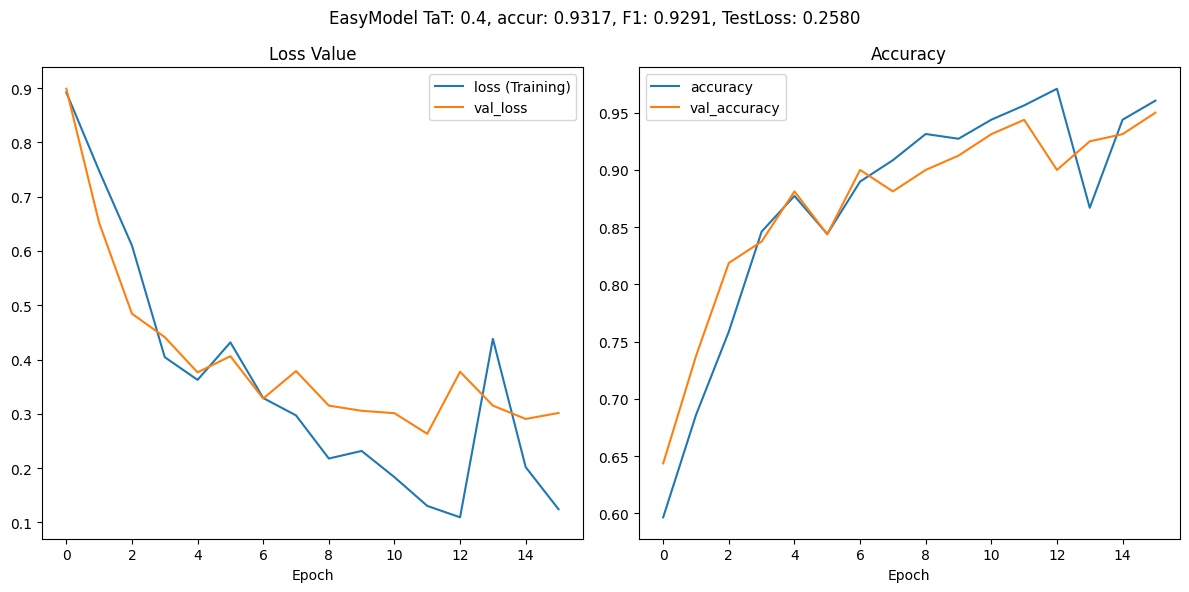

Train loss: 0.12439529597759247
Test val_loss: 0.30159687995910645
Train accuracy: 0.9604989886283875
Accuracy Score: 0.9316770186335404
F1 Score: 0.9291028727331087
Classification Report:
               precision    recall  f1-score   support

         0.0       0.91      0.97      0.94        75
         1.0       0.98      0.87      0.92        53
         2.0       0.91      0.94      0.93        33

    accuracy                           0.93       161
   macro avg       0.93      0.93      0.93       161
weighted avg       0.93      0.93      0.93       161



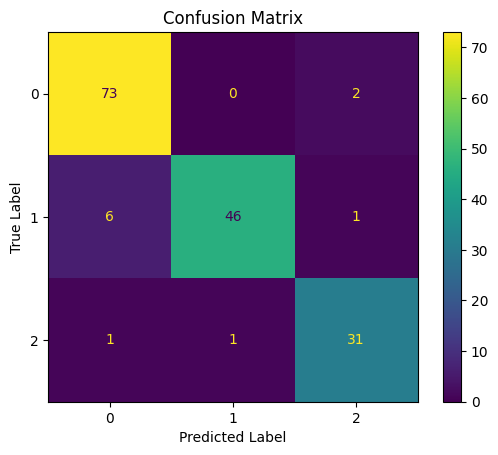

In [9]:
def build_combined_model(input_shape):
    # First Model
    input1 = Input(shape=input_shape)
    model1 = Sequential()
    model1.add(Conv1D(filters=32, kernel_size=50, strides=10, activation='relu', input_shape=input_shape))
    model1.add(MaxPooling1D(pool_size=4))
    model1.add(Conv1D(filters=64, kernel_size=10, activation='relu'))
    model1.add(MaxPooling1D(pool_size=2))
    model1.add(Conv1D(filters=64, kernel_size=4, activation='relu'))
    model1.add(GlobalMaxPooling1D())
    model1.add(Dense(64, activation='relu'))
    output1 = model1(input1)

    # Second Model
    input2 = Input(shape=input_shape)
    model2 = Sequential()
    model2.add(Conv1D(filters=32, kernel_size=20, strides=10, activation='relu', input_shape=input_shape))
    model2.add(MaxPooling1D(pool_size=4))
    model2.add(Conv1D(filters=16, kernel_size=8, activation='relu'))
    model2.add(GlobalMaxPooling1D())
    model2.add(Dense(64, activation='relu'))
    model2.add(Dropout(rate=0.2))
    model2.add(Dense(32, activation='relu'))
    
    output2 = model2(input2)

    # Third Model
    input3 = Input(shape=input_shape)
    model3 = Sequential()
    model3.add(Conv1D(filters=64, kernel_size=40, activation='relu', input_shape=input_shape))
    model3.add(MaxPooling1D(pool_size=4))
    model3.add(Conv1D(filters=32, kernel_size=20, activation='relu'))
    model3.add(MaxPooling1D(pool_size=2))
    model3.add(Conv1D(filters=16, kernel_size=10, activation='relu'))
    model3.add(GlobalMaxPooling1D())
    model3.add(Dense(64, activation='relu'))
    model3.add(Dropout(rate=0.2))
    model3.add(Dense(32, activation='relu'))
    
    output3 = model3(input3)

    merged = Concatenate()([output1, output2, output3])
    merged = Dense(N_CLASS, activation='softmax')(merged)
    combined_model = Model(inputs=[input1, input2, input3], outputs=merged)

    return combined_model


model = build_combined_model((WS_B, 1))
model.summary()
model.compile(optimizer=Adam(), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

#TRAIN THE MODEL
early_stopping = EarlyStopping(monitor='val_loss', patience=4, restore_best_weights=True)
history = model.fit([X_train, X_train, X_train], [y_train, y_train, y_train], epochs=32, batch_size=32, validation_data=([X_val, X_val, X_val], [y_val, y_val, y_val]), verbose=1, callbacks=[early_stopping])

loss, accuracy = model.evaluate([X_test, X_test, X_test], [y_test, y_test, y_test])

# Predict labels for test data
y_pred = model.predict([X_test, X_test, X_test])
y_pred_labels = np.argmax(y_pred, axis=1) 

f1 = f1_score(y_test, y_pred_labels, average='macro') 
accuracy = accuracy_score(y_test, y_pred_labels)

fig, axs = plt.subplots(1, 2, figsize=(12, 6))
# Plot Loss Value
axs[0].plot(history.history["loss"], label="loss (Training)")
axs[0].plot(history.history["val_loss"], label="val_loss")
axs[0].set_title("Loss Value")
axs[0].set_xlabel('Epoch')
axs[0].legend()

# Plot Accuracy
axs[1].plot(history.history["accuracy"], label="accuracy")
axs[1].plot(history.history["val_accuracy"], label="val_accuracy")
axs[1].set_title("Accuracy")
axs[1].set_xlabel('Epoch')
axs[1].legend()
plt.suptitle(f"EasyModel TaT: {TEST_SIZE}, accur: {accuracy:.4f}, F1: {f1:.4f}, TestLoss: {loss:.4f}")
plt.tight_layout()
plt.show()

print("Train loss:", history.history["loss"][-1])
print("Test val_loss:", history.history["val_loss"][-1])
print("Train accuracy:", history.history["accuracy"][-1])
print("Accuracy Score:", accuracy)

print("F1 Score:", f1)
print("Classification Report:\n", classification_report(y_test, y_pred_labels))

conf_mat = confusion_matrix(y_test, y_pred_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_mat, display_labels=DISP_LABEL)
disp.plot()  # You can adjust the colormap as needed
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# BEST EASY BIG KERNEL + SMALL KERNEL

/home/user/.local/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Model: "functional_62"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_10      │ (None, 2000, 1)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_12      │ (None, 2000, 1)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_5        │ (None, 128)       │    330,816 │ input_layer_10[0… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_6        │ (None, 128)       │    164,480 │ input_layer_12[0… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_2       │ (None, 256)       │          0 │ sequential_5[0][… │
│ (Concatenate)       │                   │            │ sequential_6[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_12 (Dense)    │ (None, 64)        │     16,448 │ concatenate_2[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_13 (Dense)    │ (None, 3)         │        195 │ dense_12[0][0]    │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 511,939 (1.95 MB)

 Trainable params: 511,939 (1.95 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/32
16/16 ━━━━━━━━━━━━━━━━━━━━ 19s 430ms/step - accuracy: 0.4145 - loss: 1.0860 - val_accuracy: 0.7250 - val_loss: 0.8339
Epoch 2/32
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.5923 - loss: 0.8684 - val_accuracy: 0.7937 - val_loss: 0.5808
Epoch 3/32
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.6393 - loss: 0.7341 - val_accuracy: 0.8188 - val_loss: 0.4463
Epoch 4/32
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.7360 - loss: 0.5839 - val_accuracy: 0.9125 - val_loss: 0.3429
Epoch 5/32
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.8366 - loss: 0.4252 - val_accuracy: 0.8875 - val_loss: 0.2975
Epoch 6/32
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.7341 - loss: 0.6405 - val_accuracy: 0.8687 - val_loss: 0.3575
Epoch 7/32
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.8196 - loss: 0.4685 - val_accuracy: 0.8062 - val_loss: 0.4439
Epoch 8/32
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.7644 - loss: 0.6045 - val_accuracy: 0.8313 -

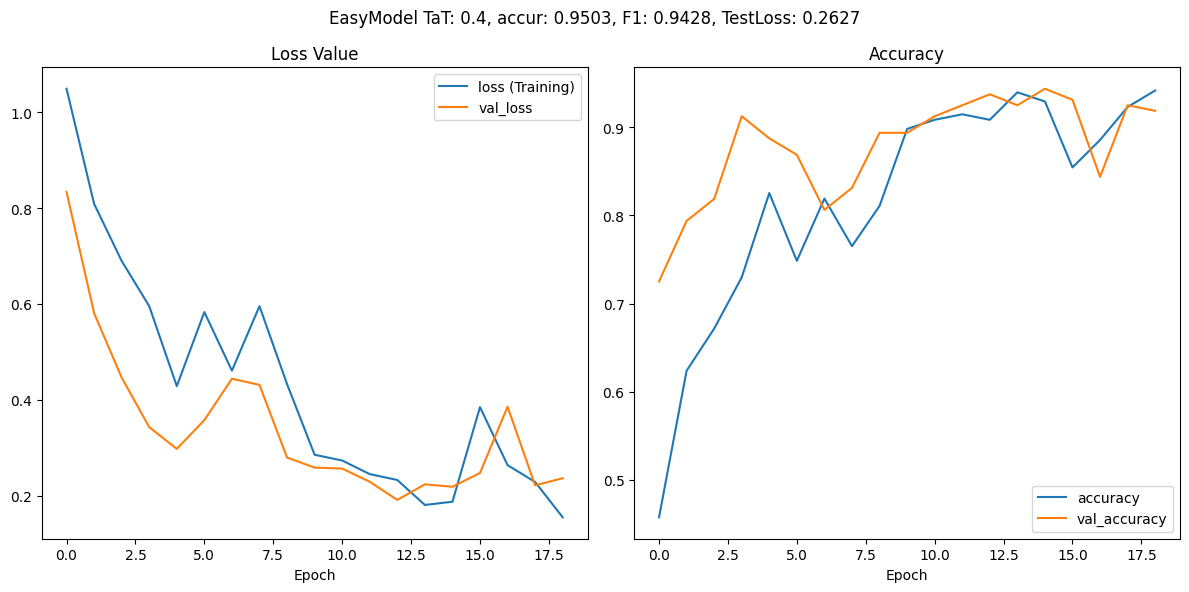

Train loss: 0.1547113060951233
Test val_loss: 0.23627236485481262
Train accuracy: 0.9417879581451416
Accuracy Score: 0.9503105590062112
F1 Score: 0.9427864262301348
Classification Report:
               precision    recall  f1-score   support

         0.0       0.96      0.97      0.97        75
         1.0       0.96      0.94      0.95        53
         2.0       0.91      0.91      0.91        33

    accuracy                           0.95       161
   macro avg       0.94      0.94      0.94       161
weighted avg       0.95      0.95      0.95       161



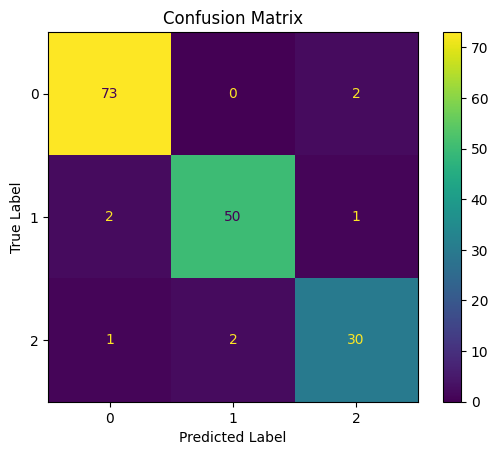

In [4]:

def build_combined_model(input_shape):
    # First Model
    input1 = Input(shape=input_shape)
    model1 = Sequential()
    model1.add(Conv1D(64, kernel_size=40, strides=10, activation='relu', input_shape=input_shape))
    model1.add(MaxPooling1D(pool_size=2))
    model1.add(Conv1D(128, kernel_size=20, activation='relu'))
    model1.add(MaxPooling1D(pool_size=2))
    model1.add(Conv1D(256, kernel_size=4, activation='relu'))
    model1.add(GlobalMaxPooling1D())
    model1.add(Dense(128, activation='relu'))
    model1.add(Dropout(0.2))
    output1 = model1(input1)

    # Second Model
    input2 = Input(shape=input_shape)
    model2 = Sequential()
    model2.add(Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=input_shape))
    model2.add(MaxPooling1D(pool_size=4))
    model2.add(Conv1D(filters=64, kernel_size=8, activation='relu'))
    model2.add(Dropout(rate=0.2))
    model2.add(Conv1D(filters=128, kernel_size=10, activation='relu'))
    model2.add(Conv1D(filters=128, kernel_size=2, activation='relu'))
    model2.add(GlobalMaxPooling1D())
    model2.add(Dense(128, activation='relu'))
    model1.add(Dropout(0.2))
    output2 = model2(input2)

    merged = Concatenate()([output1, output2])
    merged = Dense(64, activation='relu')(merged)
    merged = Dense(N_CLASS, activation='softmax')(merged)
    combined_model = Model(inputs=[input1, input2], outputs=merged)

    return combined_model


model = build_combined_model((WS_B, 1))
model.summary()
model.compile(optimizer=Adam(), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

#TRAIN THE MODEL
early_stopping = EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True)
history = model.fit([X_train,X_train], [y_train, y_train], epochs=32, batch_size=32, validation_data=([X_val, X_val], [y_val, y_val]), verbose=1, callbacks=[early_stopping])

loss, accuracy = model.evaluate([X_test, X_test], [y_test, y_test])

# Predict labels for test data
y_pred = model.predict([X_test, X_test])
y_pred_labels = np.argmax(y_pred, axis=1) 

f1 = f1_score(y_test, y_pred_labels, average='macro') 
accuracy = accuracy_score(y_test, y_pred_labels)

fig, axs = plt.subplots(1, 2, figsize=(12, 6))
# Plot Loss Value
axs[0].plot(history.history["loss"], label="loss (Training)")
axs[0].plot(history.history["val_loss"], label="val_loss")
axs[0].set_title("Loss Value")
axs[0].set_xlabel('Epoch')
axs[0].legend()

# Plot Accuracy
axs[1].plot(history.history["accuracy"], label="accuracy")
axs[1].plot(history.history["val_accuracy"], label="val_accuracy")
axs[1].set_title("Accuracy")
axs[1].set_xlabel('Epoch')
axs[1].legend()
plt.suptitle(f"EasyModel TaT: {TEST_SIZE}, accur: {accuracy:.4f}, F1: {f1:.4f}, TestLoss: {loss:.4f}")
plt.tight_layout()
plt.show()

print("Train loss:", history.history["loss"][-1])
print("Test val_loss:", history.history["val_loss"][-1])
print("Train accuracy:", history.history["accuracy"][-1])
print("Accuracy Score:", accuracy)

print("F1 Score:", f1)
print("Classification Report:\n", classification_report(y_test, y_pred_labels))

conf_mat = confusion_matrix(y_test, y_pred_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_mat, display_labels=DISP_LABEL)
disp.plot()  # You can adjust the colormap as needed
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# Probably Improved Best Combined

/home/user/.local/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Model: "functional_82"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ force_input         │ (None, 2000, 1)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_7        │ (None, 64)        │    339,072 │ force_input[0][0] │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_8        │ (None, 64)        │    119,488 │ force_input[0][0] │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_3       │ (None, 128)       │          0 │ sequential_7[0][… │
│ (Concatenate)       │                   │            │ sequential_8[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_8 (Dropout) │ (None, 128)       │          0 │ concatenate_3[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_17 (Dense)    │ (None, 64)        │      8,256 │ dropout_8[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_18 (Dense)    │ (None, 3)         │        195 │ dense_17[0][0]    │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 467,011 (1.78 MB)

 Trainable params: 467,011 (1.78 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/32


2024-05-23 17:39:31.299059: W external/local_tsl/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 6.06GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2024-05-23 17:39:31.935936: W external/local_tsl/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 4.05GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2024-05-23 17:39:31.988349: W external/local_tsl/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 4.05GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.


13/16 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.3559 - loss: 1.0936

2024-05-23 17:39:36.929207: W external/local_tsl/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 4.11GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.


16/16 ━━━━━━━━━━━━━━━━━━━━ 13s 342ms/step - accuracy: 0.3705 - loss: 1.0859 - val_accuracy: 0.5125 - val_loss: 0.9345
Epoch 2/32
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.5004 - loss: 0.9817 - val_accuracy: 0.5625 - val_loss: 0.7540
Epoch 3/32
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.5758 - loss: 0.8569 - val_accuracy: 0.7812 - val_loss: 0.5648
Epoch 4/32
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.6819 - loss: 0.7281 - val_accuracy: 0.6562 - val_loss: 0.7544
Epoch 5/32
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.6357 - loss: 0.7745 - val_accuracy: 0.7500 - val_loss: 0.5665
Epoch 6/32
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.7381 - loss: 0.5850 - val_accuracy: 0.7312 - val_loss: 0.6659
Epoch 7/32
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.7678 - loss: 0.5910 - val_accuracy: 0.7250 - val_loss: 0.5496
Epoch 8/32
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.6810 - loss: 0.6905 - val_accuracy: 0.8438 - val_loss: 

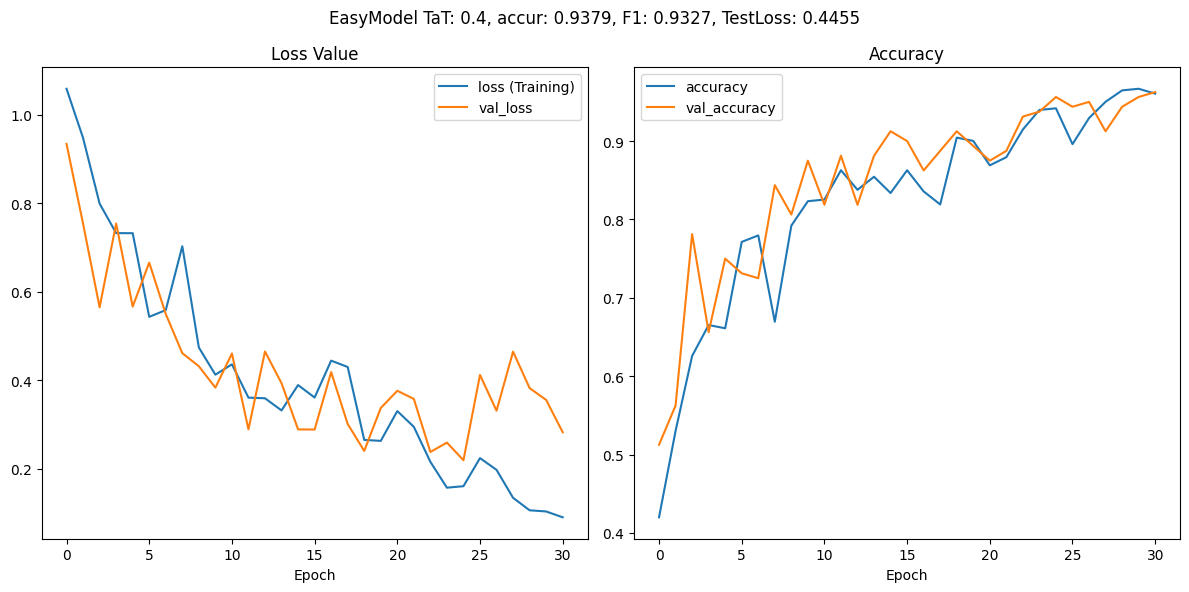

Train loss: 0.08972130715847015
Test val_loss: 0.2821430265903473
Train accuracy: 0.9604989886283875
Accuracy Score: 0.937888198757764
F1 Score: 0.9327060578146247
Classification Report:
               precision    recall  f1-score   support

         0.0       0.96      0.95      0.95        75
         1.0       0.94      0.92      0.93        53
         2.0       0.89      0.94      0.91        33

    accuracy                           0.94       161
   macro avg       0.93      0.94      0.93       161
weighted avg       0.94      0.94      0.94       161



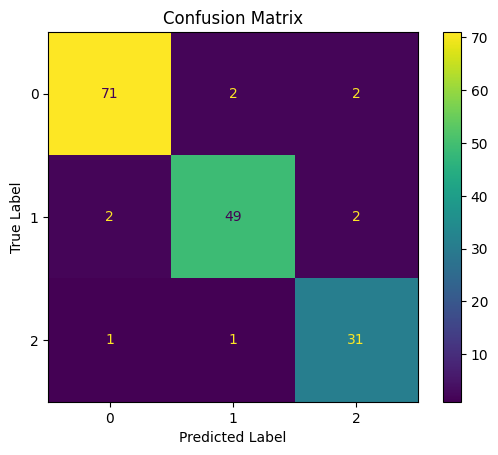

In [5]:

def build_combined_model(input_shape):
    force_input = Input(shape=input_shape, name='force_input')
    Fbranch1 = Sequential()
    Fbranch1.add(Conv1D(64, kernel_size=40, strides=8, activation='relu', input_shape=input_shape))
    Fbranch1.add(MaxPooling1D(pool_size=2))
    Fbranch1.add(Conv1D(128, kernel_size=20, strides=2, activation='relu'))
    Fbranch1.add(MaxPooling1D(pool_size=2))
    Fbranch1.add(Conv1D(256, kernel_size=4, activation='relu'))
    Fbranch1.add(GlobalMaxPooling1D())
    Fbranch1.add(Dense(128, activation='relu'))
    Fbranch1.add(Dropout(0.2))
    Fbranch1.add(Dense(64, activation='relu'))
    outF1 = Fbranch1(force_input)

    Fbranch2 = Sequential()
    Fbranch2.add(Conv1D(128, kernel_size=2,  activation='relu', input_shape=input_shape))
    Fbranch2.add(MaxPooling1D(pool_size=2))
    Fbranch2.add(Conv1D(64, kernel_size=8, strides=2, activation='relu'))
    Fbranch2.add(MaxPooling1D(pool_size=2))
    Fbranch2.add(Conv1D(128, kernel_size=4, activation='relu'))
    Fbranch2.add(Conv1D(64, kernel_size=2, activation='relu'))
    Fbranch2.add(GlobalMaxPooling1D())
    Fbranch2.add(Dropout(0.2))
    Fbranch2.add(Dense(64, activation='relu'))
    outF2 = Fbranch2(force_input)
    
    merged = concatenate([outF1, outF2])
    merged = Dropout(0.1)(merged)
    merged = Dense(64, activation='relu')(merged)
    merged = Dense(N_CLASS, activation='softmax')(merged)
    combined_model = Model(inputs=[force_input, force_input], outputs=merged)

    return combined_model


model = build_combined_model((WS_B, 1))
model.summary()
model.compile(optimizer=Adam(), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

#TRAIN THE MODEL
early_stopping = EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True)
history = model.fit([X_train,X_train], [y_train, y_train], epochs=32, batch_size=32, validation_data=([X_val, X_val], [y_val, y_val]), verbose=1, callbacks=[early_stopping])

loss, accuracy = model.evaluate([X_test, X_test], [y_test, y_test])

# Predict labels for test data
y_pred = model.predict([X_test, X_test])
y_pred_labels = np.argmax(y_pred, axis=1) 

f1 = f1_score(y_test, y_pred_labels, average='macro') 
accuracy = accuracy_score(y_test, y_pred_labels)

fig, axs = plt.subplots(1, 2, figsize=(12, 6))
# Plot Loss Value
axs[0].plot(history.history["loss"], label="loss (Training)")
axs[0].plot(history.history["val_loss"], label="val_loss")
axs[0].set_title("Loss Value")
axs[0].set_xlabel('Epoch')
axs[0].legend()

# Plot Accuracy
axs[1].plot(history.history["accuracy"], label="accuracy")
axs[1].plot(history.history["val_accuracy"], label="val_accuracy")
axs[1].set_title("Accuracy")
axs[1].set_xlabel('Epoch')
axs[1].legend()
plt.suptitle(f"EasyModel TaT: {TEST_SIZE}, accur: {accuracy:.4f}, F1: {f1:.4f}, TestLoss: {loss:.4f}")
plt.tight_layout()
plt.show()

print("Train loss:", history.history["loss"][-1])
print("Test val_loss:", history.history["val_loss"][-1])
print("Train accuracy:", history.history["accuracy"][-1])
print("Accuracy Score:", accuracy)

print("F1 Score:", f1)
print("Classification Report:\n", classification_report(y_test, y_pred_labels))

conf_mat = confusion_matrix(y_test, y_pred_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_mat, display_labels=DISP_LABEL)
disp.plot()  # You can adjust the colormap as needed
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()